# 1. Set up the notebook

Import modules.

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym
from scipy.interpolate import interp1d
from scipy.signal import find_peaks
from IPython.display import display, IFrame, HTML

Define a function to load flight data from hardware experiments and resample it at 100 Hz using linear interpolation.

In [2]:
def load_hardware_data(filename, t_min_offset=0, t_max_offset=0):
    # load raw data
    with open(filename, 'r') as f:
        data = json.load(f)

    # convert lists to numpy arrays
    for val in data.values():
        for key in val.keys():
            val[key] = np.array(val[key])

    # create an array of times at which to subsample
    t_min = -np.inf
    t_max = np.inf
    for key, val in data.items():
        t_min = max(t_min, val['time'][0])
        t_max = min(t_max, val['time'][-1])
    t_min += t_min_offset * 1000
    t_max -= t_max_offset * 1000
    nt = int(1 + np.floor((t_max - t_min) / 10.))
    t = np.arange(0, 10 * nt, 10) / 1000.
    resampled_data = {'time': t}

    # resample raw data with linear interpolation
    for k, v in data.items():
        f = interp1d((v['time'] - t_min) / 1000., v['data'])
        resampled_data[k] = f(t)
        
    # return the resampled data
    return resampled_data

Define a function to embed videos that have been uploaded to [Illinois Mediaspace](https://mediaspace.illinois.edu/).

In [3]:
def mediaspace(url, width=640, height=397):
    video_id = url.rsplit('/', 1)[-1]
    src = f'https://mediaspace.illinois.edu/embed/secure/iframe/entryId/{video_id}?st=0'
    display(IFrame(src, width=width, height=height))
    display(HTML(f'<a href="{url}" target="_blank">Go to video on Illinois Mediaspace</a>'))

# 2. Define constants

Define the acceleration of gravity in $\text{kg}\cdot\text{m} \;/\; \text{s}^2$:

In [4]:
g = 9.81    # acceleration of gravity in [kgm/s^2]
m = 0.0316  # mass of drone in [kg]

# 3. Estimate the moment of inertia about the $x$-axis

In [5]:
r = 0.034 # the distance in meters between the axis of rotation and the center of mass

![x-axis-rig](x.jpg)

Show a video of the drone swinging on your rig, while you were collecting data (change the url as appropriate):

In [6]:
mediaspace('https://mediaspace.illinois.edu/media/t/1_nbbr3a27')

Load and resample data.

The `load_hardware_data` function has two optional arguments:

* `t_min_offset` allows you to discard data at the *start* of the experiment - if its value is `4.`, for example, then the *first* four seconds of data will be discarded
* `t_max_offset` allows you to discard data at the *end* of the experiment - if its value is `4.`, for example, then the *last* four seconds of data will be discarded

You may find these arguments useful, since you will likely find that some of the data at the start and end of your experiment are garbage.

In [7]:
data = load_hardware_data(
    'logged_data_x_NEW.json',
    t_min_offset=0.,
    t_max_offset=0.
)

Parse data to get time and the three components of angular velocity (in radians / second).

In [8]:
t = data['time']
w_x = np.deg2rad(data['gyro.x'])
w_y = np.deg2rad(data['gyro.y'])
w_z = np.deg2rad(data['gyro.z'])

cutOffTime = 18
for i in np.arange(len(t)):
    if t[i] < cutOffTime:
        cutOff = i

In [9]:
t = t[0:cutOff]
w_x = w_x[0:cutOff]
w_y = w_y[0:cutOff]
w_z = w_z[0:cutOff]

Plot all three components of angular velocity. You are trying to estimate the moment of inertia about the $x$ axis. The component of angular velocity about this axis should be large, and the components of angular velocity about the other two axes should be negligibly small. It is important to check this.

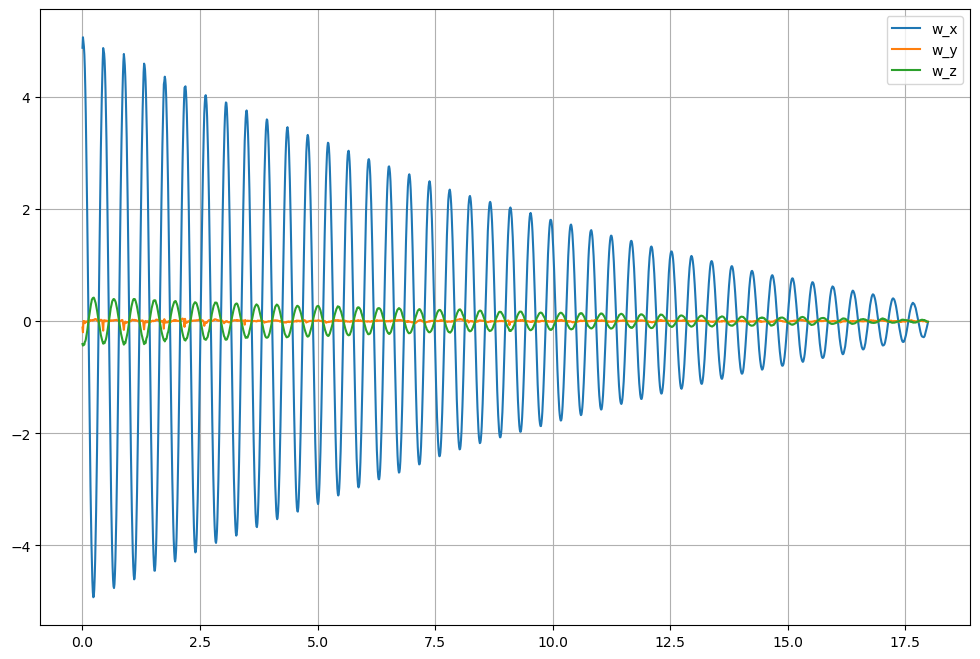

In [10]:
plt.figure(figsize=(12, 8))
plt.plot(t, w_x, label='w_x')
plt.plot(t, w_y, label='w_y')
plt.plot(t, w_z, label='w_z')
plt.legend()
plt.grid()

You should find that `w_x` is oscillatory. The period is the peak-to-peak time. You could measure the period by hand, but it is easier to automate this process, particularly if you want to average your estimate of the period over many oscillations.

Here is one way to do it:

* Find the index $i_k$ of each peak $k\in\{0, \dotsc, n-1\}$ in your data.
* Find the time $t_k$ at each peak for $k\in\{0, \dotsc, n-1\}$.
* Find the difference $T_k = t_{k+1} - t_k$ between consecutive peak times for $k \in \{0, \dotsc, n-2\}$.
* Find the mean difference: $$\widehat{T} = \dfrac{1}{n-1} \sum_{k=0}^{n-2} T_k.$$ This is an estimate of the oscillation period.

Here is one way to implement this in code, using [scipy.signal.find_peaks](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html):

In [11]:
# Find the index of each peak (increase "prominence" if you get bad results)
peaks = find_peaks(w_x, prominence=0)
i_peaks = peaks[0]

# Find the time at each peak
t_peaks = t[i_peaks]

# Find w_x at each peak (for visualization)
w_x_peaks = w_x[i_peaks]

# Find the difference between consecutive peak times
#
# Note:
#
#  t_peaks[1:] means t_peaks without the first element
#  t_peaks[:-1] means t_peaks without the last element
#
# So, t_peaks[1:] - t_peaks[:-1] produces the following array:
#
#  [t_peaks[1]-t_peaks[0], t_peaks[0]-t_peaks[1], ...]
#
t_diff = t_peaks[1:] - t_peaks[:-1]

# Find the mean difference as an estimate of the oscillation period
T = np.mean(t_diff)

Sanity check - print the peak times:

In [12]:
print(t_peaks)

[1.000e-02 4.400e-01 8.800e-01 1.310e+00 1.750e+00 2.190e+00 2.620e+00
 3.050e+00 3.490e+00 3.920e+00 4.360e+00 4.790e+00 5.220e+00 5.660e+00
 6.090e+00 6.520e+00 6.950e+00 7.380e+00 7.810e+00 8.240e+00 8.670e+00
 9.100e+00 9.530e+00 9.960e+00 1.039e+01 1.082e+01 1.124e+01 1.167e+01
 1.210e+01 1.253e+01 1.295e+01 1.338e+01 1.381e+01 1.424e+01 1.467e+01
 1.510e+01 1.553e+01 1.595e+01 1.638e+01 1.681e+01 1.724e+01 1.766e+01]


Sanity check - plot the peaks:

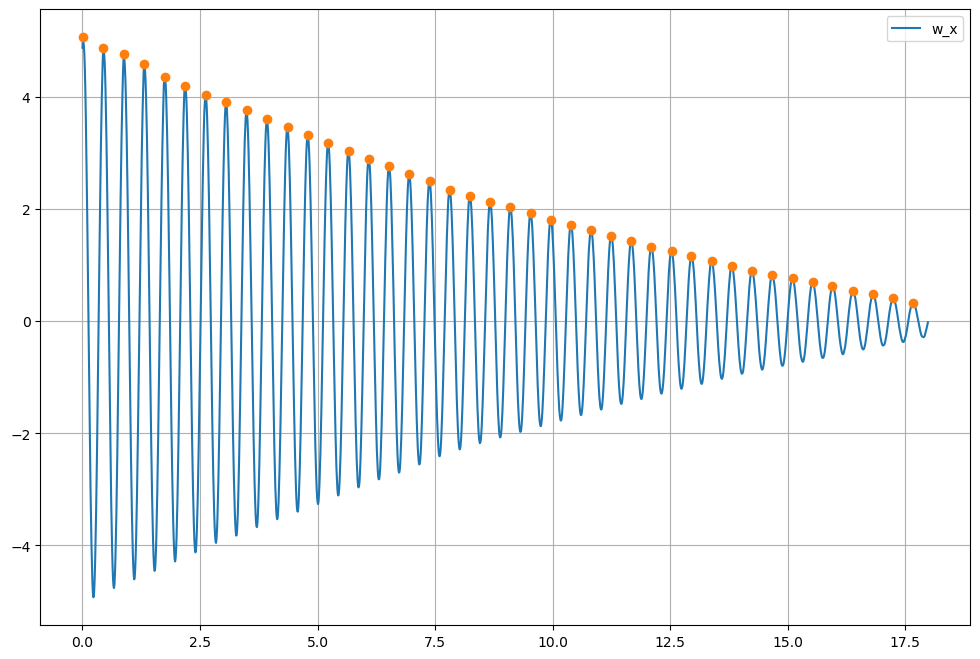

In [13]:
plt.figure(figsize=(12, 8))
plt.plot(t, w_x, label='w_x')
plt.plot(t_peaks, w_x_peaks, '.', markersize=12)
plt.legend()
plt.grid()

Sanity check - print the difference between consecutive peak times, as well as the resulting estimate of the oscillation period (you may also want to look at a histogram of the time differences, or to compute their variance):

In [14]:
print(f'time differences: {t_diff}\n')
print(f'period estimate (i.e., mean time difference): T = {T:.4f}')

time differences: [0.43 0.44 0.43 0.44 0.44 0.43 0.43 0.44 0.43 0.44 0.43 0.43 0.44 0.43
 0.43 0.43 0.43 0.43 0.43 0.43 0.43 0.43 0.43 0.43 0.43 0.42 0.43 0.43
 0.43 0.42 0.43 0.43 0.43 0.43 0.43 0.43 0.42 0.43 0.43 0.43 0.42]

period estimate (i.e., mean time difference): T = 0.4305


Compute the moment of inertia about the $x$ axis (see formula from theory).

In [15]:
J_x = (m*g*r/(2 * np.pi/T)**2) - m*r**2
J_x # kgm^2

1.2946672900712955e-05

# 4. Estimate the moment of inertia about the $y$-axis

![y-axis-rig](y.jpg)

In [16]:
mediaspace('https://mediaspace.illinois.edu/media/t/1_dn6r3w7j')

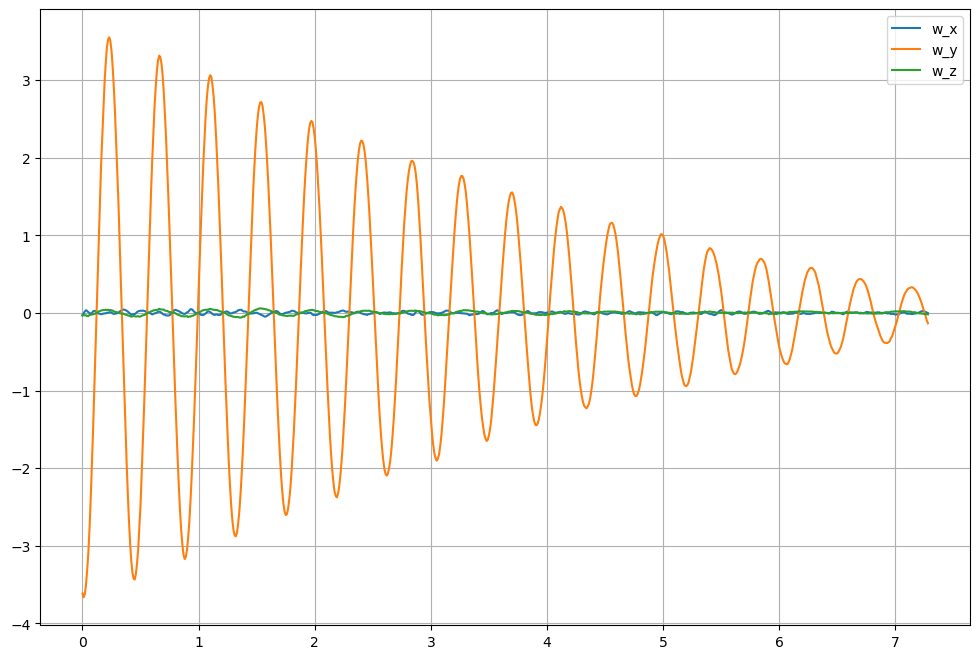

In [17]:
data = load_hardware_data(
    'logged_data_y_NEW.json',
    t_min_offset=0.,
    t_max_offset=0.
)

t = data['time']
w_x = np.deg2rad(data['gyro.x'])
w_y = np.deg2rad(data['gyro.y'])
w_z = np.deg2rad(data['gyro.z'])

cutOffTime = 7.3
for i in np.arange(len(t)):
    if t[i] < cutOffTime:
        cutOff = i

t = t[0:cutOff]
w_x = w_x[0:cutOff]
w_y = w_y[0:cutOff]
w_z = w_z[0:cutOff]

plt.figure(figsize=(12, 8))
plt.plot(t, w_x, label='w_x')
plt.plot(t, w_y, label='w_y')
plt.plot(t, w_z, label='w_z')
plt.legend()
plt.grid()

In [18]:
r = 0.034
# Find the index of each peak (increase "prominence" if you get bad results)
peaks = find_peaks(w_y, prominence=0)
i_peaks = peaks[0]

# Find the time at each peak
t_peaks = t[i_peaks]

# Find w_x at each peak (for visualization)
w_y_peaks = w_y[i_peaks]

# Find the difference between consecutive peak times
#
# Note:
#
#  t_peaks[1:] means t_peaks without the first element
#  t_peaks[:-1] means t_peaks without the last element
#
# So, t_peaks[1:] - t_peaks[:-1] produces the following array:
#
#  [t_peaks[1]-t_peaks[0], t_peaks[0]-t_peaks[1], ...]
#
t_diff = t_peaks[1:] - t_peaks[:-1]

# Find the mean difference as an estimate of the oscillation period
T = np.mean(t_diff)

print("t peaks", t_peaks)

print(f'time differences: {t_diff}\n')
print(f'period estimate (i.e., mean time difference): T = {T:.4f}')


J_y = (m*g*r/(2 * np.pi/T)**2) - m*r**2
J_y # kgm^2

t peaks [0.23 0.66 1.1  1.54 1.97 2.4  2.84 3.27 3.7  4.12 4.56 4.98 5.4  5.84
 6.28 6.69 7.14]
time differences: [0.43 0.44 0.44 0.43 0.43 0.44 0.43 0.43 0.42 0.44 0.42 0.42 0.44 0.44
 0.41 0.45]

period estimate (i.e., mean time difference): T = 0.4319


1.3266049314282399e-05

In [19]:
J_y

1.3266049314282399e-05

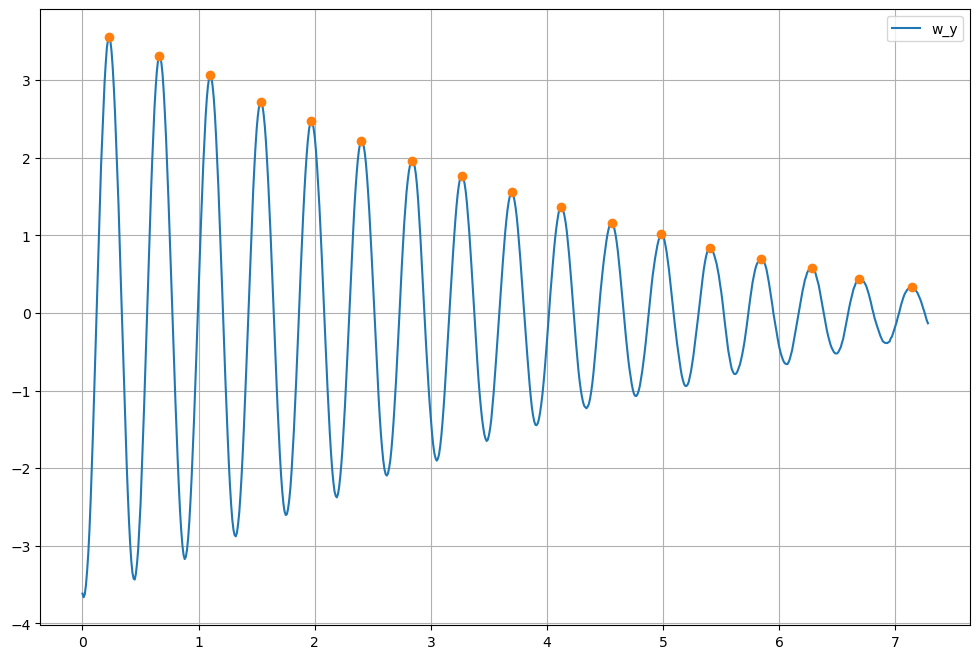

In [20]:
plt.figure(figsize=(12, 8))
plt.plot(t, w_y, label='w_y')
plt.plot(t_peaks, w_y_peaks, '.', markersize=12)
plt.legend()
plt.grid()

# 5. Estimate the moment of inertia about the $z$-axis

![z-axis-rig](z.jpg)

In [21]:
mediaspace('https://mediaspace.illinois.edu/media/t/1_2h0kvlmo')

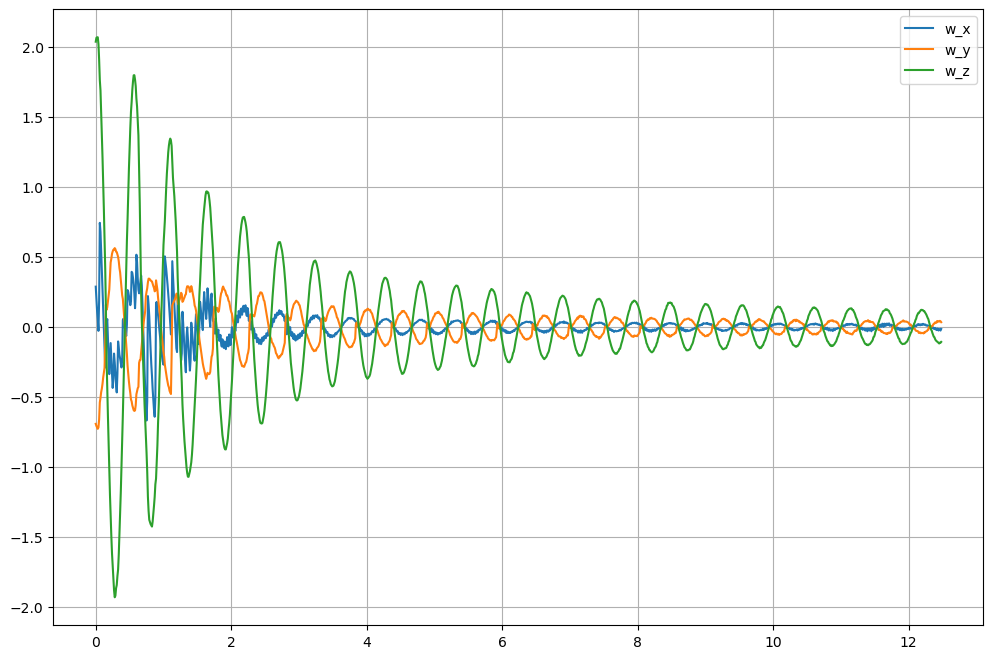

In [22]:
r = 0.016

data = load_hardware_data(
    'logged_data_z_NEW.json',
    t_min_offset=0.,
    t_max_offset=0.
)

t = data['time']
w_x = np.deg2rad(data['gyro.x'])
w_y = np.deg2rad(data['gyro.y'])
w_z = np.deg2rad(data['gyro.z'])

cutOffTime = 12.5
for i in np.arange(len(t)):
    if t[i] < cutOffTime:
        cutOff = i
        
t = t[0:cutOff]
w_x = w_x[0:cutOff]
w_y = w_y[0:cutOff]
w_z = w_z[0:cutOff]

plt.figure(figsize=(12, 8))
plt.plot(t, w_x, label='w_x')
plt.plot(t, w_y, label='w_y')
plt.plot(t, w_z, label='w_z')
plt.legend()
plt.grid()

In [23]:
# Find the index of each peak (increase "prominence" if you get bad results)
peaks = find_peaks(w_z, prominence=0.2)
i_peaks = peaks[0]

# Find the time at each peak
t_peaks = t[i_peaks]

# Find w_x at each peak (for visualization)
w_z_peaks = w_z[i_peaks]

# Find the difference between consecutive peak times
#
# Note:
#
#  t_peaks[1:] means t_peaks without the first element
#  t_peaks[:-1] means t_peaks without the last element
#
# So, t_peaks[1:] - t_peaks[:-1] produces the following array:
#
#  [t_peaks[1]-t_peaks[0], t_peaks[0]-t_peaks[1], ...]
#
t_diff = t_peaks[1:] - t_peaks[:-1]

# Find the mean difference as an estimate of the oscillation period
T = np.mean(t_diff)

print(t_peaks)

print(f'time differences: {t_diff}\n')
print(f'period estimate (i.e., mean time difference): T = {T:.4f}')


J_z = (m*g*r/(2 * np.pi/T)**2) - m*r**2
J_z # kgm^2

[ 0.57  1.1   1.64  2.19  2.72  3.24  3.75  4.28  4.79  5.32  5.84  6.36
  6.89  7.43  7.95  8.48  9.    9.55 10.07 10.61 11.15 11.66 12.19]
time differences: [0.53 0.54 0.55 0.53 0.52 0.51 0.53 0.51 0.53 0.52 0.52 0.53 0.54 0.52
 0.53 0.52 0.55 0.52 0.54 0.54 0.51 0.53]

period estimate (i.e., mean time difference): T = 0.5282


2.6960013268899122e-05

In [24]:
J_z

2.6960013268899122e-05

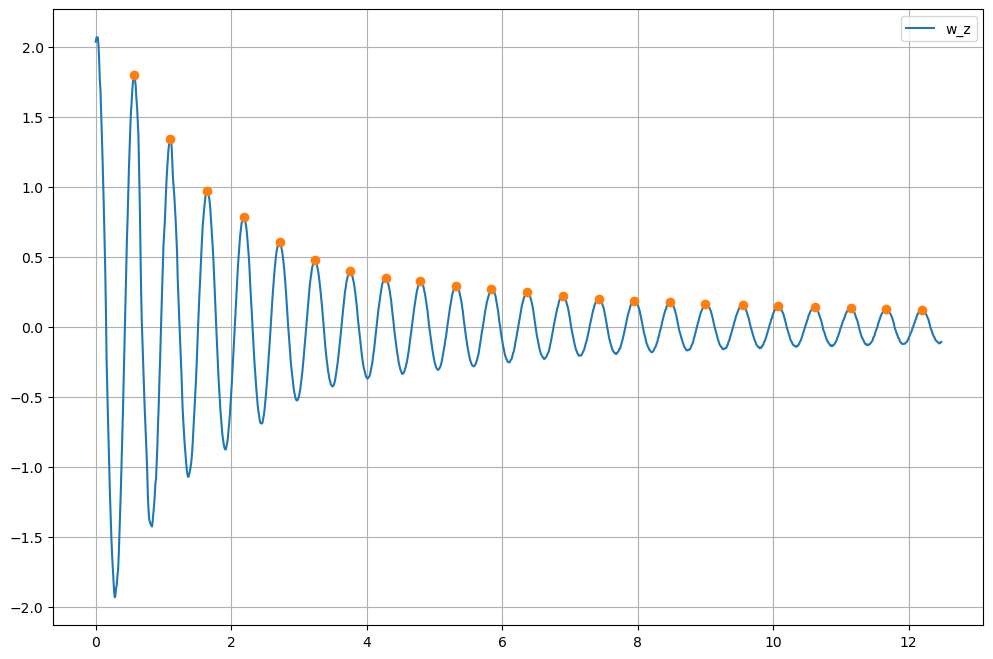

In [25]:
plt.figure(figsize=(12, 8))
plt.plot(t, w_z, label='w_z')
plt.plot(t_peaks, w_z_peaks, '.', markersize=12)
plt.legend()
plt.grid()

# 6. Summarize and discuss the results

### Summary of results

In [26]:
print(f'm = {m:.2} kg')
print(f'J_x = {J_x:.2e} kg m^2')
print(f'J_y = {J_y:.2e} kg m^2')
print(f'J_z = {J_z:.2e} kg m^2')

m = 0.032 kg
J_x = 1.29e-05 kg m^2
J_y = 1.33e-05 kg m^2
J_z = 2.70e-05 kg m^2


### Sources of error

**Modify the text in this cell** to discuss possible sources of error. For example:
How uncertain was each measurement and each computed quantity?  

* The r value measured by the ruler is $\pm$0.01 m

What assumptions were made and to what extent were these assumptions violated?

* We assumed that there was no friction from the nail on the drone.

Are there ways in which either the experiments or the analysis could be improved?

* The analysis could be improved by improving the z-axis data. The drone propellers hit the wooden block that the drone was resting on, which limited the accuracy of this analysis. Additionally, we could do a better job of restricting motion to be solely in the z-axis.

* More tests could be run to reduce the uncertainty and account for outliers.

### Analysis of sensitivity

**Modify the text in this cell** to discuss the sensitivity of your results to possible sources of error. For example:
Find the derivative of $J$ with respect to $m$. If you overestimate the mass, will you have overestimated or underestimated $J$?

* overestimating mass leads to an overestimate for J

Find the derivative of $J$ with respect to $r$. If you overestimate the distance between the axis of rotation and the center of mass, will you have overestimated or underestimated $J$?

* r becomes an overestimate when $\frac{dr}{dJ}$ is positive, and r is an underestimate when $\frac{dr}{dJ}$ is negative.

Find the derivative of $J$ with respect to $T$. If you overestimate the period of oscillation, will you have overestimated or underestimated $J$?

* overestimating T leads to an overestimate for J

In [27]:
J, g, r, T, m = sym.symbols('J,g,r,T,m')

f = m*g*r/(2 * sym.pi /T)**2 - m*r**2
sym.diff(f,m)

T**2*g*r/(4*pi**2) - r**2

In [28]:
f = m*g*r/(2 * sym.pi /T)**2 - m*r**2
sym.diff(f,r)

T**2*g*m/(4*pi**2) - 2*m*r

In [29]:
f = m*g*r/(2 * sym.pi /T)**2 - m*r**2
sym.diff(f,T)

T*g*m*r/(2*pi**2)